In [75]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from qiskit.circuit.library import GroverOperator, MCMT, ZGate



In [76]:
def grover_phase_oracle(marked):
    num_qubits = len(marked[0])

    oracle = QuantumCircuit(num_qubits)

    for state in marked:
        qstate = state[::-1]
        flip = [i for i in range(num_qubits) if qstate.startswith("0",i)]
        oracle.x(flip)
        oracle.compose(MCMT(ZGate(),num_qubits-1,1), inplace=True)
        oracle.x(flip)
    
    return oracle


C:\Users\sunfr\AppData\Local\Temp\ipykernel_28628\440864009.py:10: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  oracle.compose(MCMT(ZGate(),num_qubits-1,1), inplace=True)


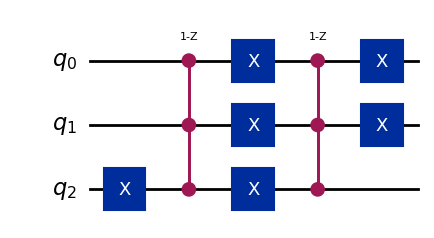

In [77]:
marked_states = ["011", "100"]

oracle = grover_phase_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

In [78]:
def filter_oracle(threshold):
    num_qubits = len(threshold)
    print(num_qubits)
    oracle = QuantumCircuit(num_qubits, name="Oracle")

    state = threshold[::-1]
    bstr = [int(b) for b in state]
    print(bstr)

    temp = []
    max = num_qubits - 1

    

    for i in reversed(range(num_qubits)):
        print(i, bstr[i])
        if bstr[i] == 0:
            
            if i != max:
                
                controls = list(range(i + 1, num_qubits))
                cz = ZGate().control(len(controls))
                target = i

                #equivalent to multi control z
                # oracle.h(target)
                # oracle.mcx(controls, target, mode='noancilla')
                # oracle.h(target)

                all_qubits = [oracle.qubits[i] for i in controls + [target]]
                oracle.append(cz, all_qubits)
            else:
                print("max",i)
                oracle.z(i)
            oracle.x(i)
            temp.append(i)
    oracle.x(temp)
    return oracle.to_gate()
    
        


3
[1, 0, 0]
2 0
max 2
1 0
0 1


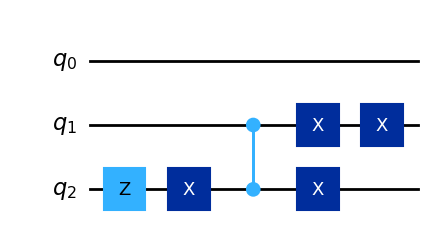

In [79]:
qc = QuantumCircuit(3)

oracle = filter_oracle("001")
qc.append(oracle, qc.qubits)

qc.decompose().draw('mpl')

3
[0, 1, 0]
2 0
max 2
1 1
0 0


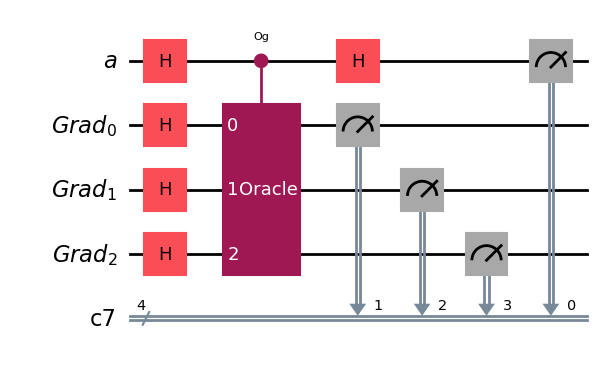

In [ ]:
a = QuantumRegister(1, name='a')
grad = QuantumRegister(3,name='Grad')
cr = ClassicalRegister(4)

qc = QuantumCircuit(a, grad, cr)

qc.h(grad)

qc.h(a)

og = filter_oracle("010")
cog = og.control(1,label="Og")
qc.append(cog, list(a) + list(grad))

qc.h(a[0])
qc.measure(list(a) + list(grad), range(4))


qc.draw('mpl')


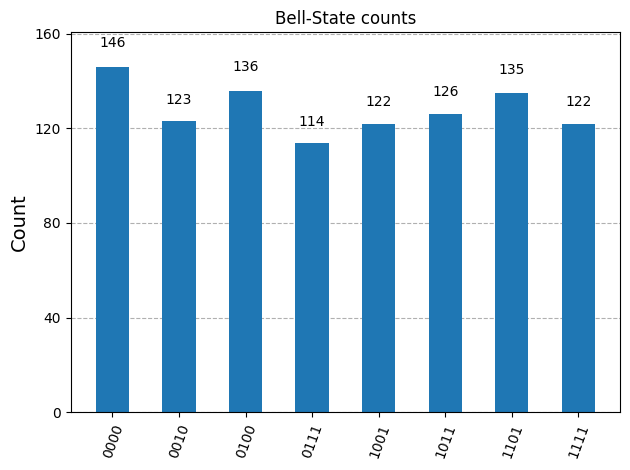

In [81]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')